In [1]:
%matplotlib inline
 
import logging
import sys
import re
from os.path import join as pjoin
from glob import glob

import xarray
import netCDF4
import cftime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as feature
import scipy.stats as stats
import Utilities.metutils

In [2]:
sys.path.append('../scripts')
import TCLVscaling
logging.disable(logging.INFO)

16:29:13: <module>: Started /home/jami/.anaconda3/envs/tcrm-r/lib/python3.7/site-packages/ipykernel_launcher.py (pid 15116)
16:29:13: <module>: Code version: funknown


In [3]:
simulated_track_path = "../data/tclv"
PI_path = "../data/PI"
domain = [135, 160, -25, -10]

In [4]:
ls "../data/tclv/all_tracks_ACCESS1-0Q_rcp45.dat"

../data/tclv/all_tracks_ACCESS1-0Q_rcp45.dat


In [5]:
def plot_model_dists(data):
    fig, axes = plt.subplots(6,4, figsize=(20,20), sharex=True)
    ax = axes.flatten()
    result = pd.DataFrame(columns=['Model', 'RCP', 'mu', 'sigma', 'zeta'])
    for i, (m, df) in enumerate(data.items()):
        sns.distplot(df.pdiff, ax=ax[i], kde=False, norm_hist=True)
        model, rcp = m.split(' ')
        popt = stats.lognorm.fit(df.pdiff, loc=0, scale=1)
        result = result.append({'Model':model, 'RCP':rcp, 
                                'mu':popt[0], 'sigma':popt[1], 'zeta':popt[2]},
                               ignore_index=True)
        fitline = stats.lognorm.pdf(np.arange(0, 101), *popt, )
        ax[i].plot(np.arange(0,101), fitline, color='r')
        ax[i].set_title("{0}\n({1:.4f}, {2:.4f}, {3:.4f})".format(m, *popt))
    
    fig.tight_layout()

    return result   

def plot_model_params(params):
    fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    x = np.arange(0, 100)

    def plot_ensemble(axes, ensemble):
        for index, row in refparams[refparams['RCP']==ensemble].iterrows():
            popt = (row.mu, row.sigma, row.zeta)
            fitline = stats.lognorm.pdf(x, *popt)
            if row.Model == 'ENS':
                axes.plot(x, fitline, color='b')
            else:
                axes.plot(x, fitline, color='k')

        axes.plot(x, stats.lognorm.pdf(x, *obsparams), 'r', label='Observations')
        axes.set_xlabel(r"$\Delta p_c$ (hPa)")
    
    plot_ensemble(ax[0], 'RCP45')
    ax[0].set_title("RCP4.5")

    plot_ensemble(ax[1], 'RCP85')
    ax[1].set_title("RCP8.5")

    ax[0].set_ylabel("Probability")
    ax[1].legend()
    fig.tight_layout()

In [6]:
def get_lmi(df):
    return df.loc[df.groupby('num')["pdiff"].idxmax()].set_index(['num'])

In [7]:
def dtnl(dt):
    return cftime.DatetimeNoLeap(dt.year, dt.month, dt.day, hour=dt.hour, minute=dt.minute, second=dt.second)

In [8]:
obstc = TCLVscaling.loadObsData('../data/ibtracs.since1980.list.v04r00.csv', domain)

In [9]:
refdata = TCLVscaling.loadTCLVdata(simulated_track_path, 1980, 2010, domain)
for key, df in refdata.items():
    refdata[key] = df[df['pdiff'] > 0]
refdata = TCLVscaling.append_ensembles(refdata)

In [10]:
futdata = TCLVscaling.loadTCLVdata(simulated_track_path, 2020, 2100, domain)
for key, df in futdata.items():
    futdata[key] = df[df['pdiff'] > 0]
futdata = TCLVscaling.append_ensembles(futdata)

In [11]:
brefdata = {}
bfutdata = {}
obslmi = obstc.loc[obstc.groupby(["num"])["pdiff"].idxmax()]

for i, (m, refdf) in enumerate(refdata.items()):
    futdf = futdata[m]
         
    # Determine LMI for each event in the reference and projected data
    try:
        srefdata = get_lmi(refdf)
        sfutdata = get_lmi(futdf)
    except:
        print(f"Reference data: {refdf.groupby('num')['pdiff'].idxmax():.2f}")
        print(f"Projected data: {futdf.groupby('num')['pdiff'].idxmax():.2f}")
        
    # Calculate the bias-corrected LMI
    try:
        srefdata['blmi'], sfutdata['blmi'] = TCLVscaling.qdm(obslmi.pdiff.values,
                                                             srefdata.pdiff.values,
                                                             sfutdata.pdiff.values)
    except:
        print(f"QDM failed for {m}")
        raise
        
    brefdf = refdf.copy()
    bfutdf = futdf.copy()
    
    newdf = pd.merge(brefdf, srefdata['blmi'], on='num')
    brefdf['pdiff'] = brefdf['ni'].values * newdf['blmi'].values
    brefdf['pmin'] = brefdf['poci'] - brefdf['pdiff']
    brefdf = TCLVscaling.calculateMaxWind(brefdf, 'datetime')

    newdf = pd.merge(bfutdf, sfutdata['blmi'], on='num')
    bfutdf['pdiff'] = bfutdf['ni'].values * newdf['blmi'].values
    bfutdf['pmin'] = bfutdf['poci'] - bfutdf['pdiff']
    bfutdf = TCLVscaling.calculateMaxWind(bfutdf, 'datetime')
    
    brefdata[m] = brefdf
    bfutdata[m] = bfutdf

In [12]:
model = 'MPI-ESM-LRQ'
rcp = 'RCP45'

In [20]:
lmi = get_lmi(bfutdata[model + ' ' + rcp])[['datetime', 'year', 'lat', 'lon', 'vmax']]

In [21]:
data = xarray.concat([xarray.open_dataset(fl)
                      for fl in sorted(glob(pjoin(PI_path, f"pcmin.{model}_{rcp.lower()}.*.nc")))], dim='time')

In [22]:
lmi['vmax_td'] = lmi.apply(lambda x: data.vmax.sel(latitude=x.lat,
                                                   longitude=x.lon,
                                                   time=dtnl(x.datetime), method='nearest'),
                           axis='columns')

In [23]:
lmi["vmax_td"] = Utilities.metutils.convert(lmi["vmax_td"], "mps", "kts")

In [24]:
lmi

,datetime,year,lat,lon,vmax,vmax_td
num,,,,,,
2350,2020-01-24 12:00:00,2020,-23.2,155.1,57.554114,88.690454
2351,2020-01-22 00:00:00,2020,-14.1,144.3,29.807277,116.189707
2355,2020-01-25 00:00:00,2020,-13.7,137.3,28.944184,129.164259
2356,2020-02-05 18:00:00,2020,-14.6,137.1,76.137693,133.326331
2360,2020-03-01 00:00:00,2020,-13.1,157.2,32.009658,119.062414
...,...,...,...,...,...,...
6018,2097-12-25 00:00:00,2097,-14.7,136.8,34.147252,139.003801
6019,2097-12-26 12:00:00,2097,-17.0,158.4,29.925592,102.887303
6023,2098-02-10 00:00:00,2098,-15.9,150.0,45.663932,108.993272


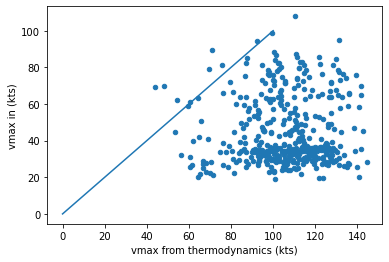

In [25]:
# after conversion
ax = lmi.plot.scatter('vmax_td', 'vmax')
ax.plot(np.linspace(0, 100), np.linspace(0, 100))
plt.ylabel("vmax in (kts)")
plt.xlabel("vmax from thermodynamics (kts)")
plt.savefig("comparison of PI vs vmax")